In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
plt.rcParams['figure.figsize'] = [12.0, 10.0]

## Load Employees

In [10]:
employees = pd.read_pickle('v3/employees.pickle')

In [11]:
employees = employees[employees.Role.notnull()]

In [ ]:
employees.head()

In [13]:
roles = pd.DataFrame(employees.Role.values, index=employees.Employee_ThreeFour.values).to_dict()[0]

## Load Hierarchy

In [18]:
org = pd.read_pickle('v3/hierarchy.pickle')

### Positions

In [21]:
positions = pd.DataFrame(columns=['Employee_ThreeFour','Employee_Num','Employee_Name','Position'])

In [22]:
subset = pd.merge(employees, org, left_on='Employee_ThreeFour', right_on='Employee_ThreeFour', how='left').drop_duplicates()

In [ ]:
subset.info()

In [24]:
temp = subset[['Employee_ThreeFour','Employee_Num','Employee_Name','Position_Code_Desc']]
temp.columns=['Employee_ThreeFour','Employee_Num','Employee_Name','Position']
positions = positions.append(temp.dropna().drop_duplicates(), ignore_index=True)

In [25]:
for i in [10,9,8,7,6,5,4,3,2,1]:
    temp = subset[['Sup_34_ID%i' %i,'Sup_Emp_Num%i' %i,'Sup_Name%i' %i,'Supervisor_Position_Desc%i' %i]]
    temp.columns=['Employee_ThreeFour','Employee_Num','Employee_Name','Position']
    positions = positions.append(temp.dropna().drop_duplicates(), ignore_index=True)

In [26]:
positions.drop_duplicates(inplace=True, ignore_index=True)

In [27]:
del subset
del temp

## Network Analysis

In [30]:
subset = pd.merge(employees, org, left_on='Employee_ThreeFour', right_on='Employee_ThreeFour', how='left').drop_duplicates()

In [31]:
def role_to_weight(s):
    switcher = { 
        'EDW' : 1.0,  # Non-BI EDW Profile
        'CDA' : 1.0,  # Cloudera Profile
        'DSC' : 1.0,  # Data Science Profile
        'BIM' : 1.0,  # Main Stream BI Profile 
        'BIA' : 1.0,  # Alternation BI Profile
        'BIL' : 1.0   # Legacy BI Profile
    }
    
    return switcher.get(s, 0) 

In [32]:
G = nx.DiGraph()

# Managment Structure

for i in [10,9,8,7,6,5,4,3,2] :

    mgr = 'Sup_34_ID%i' %i
    mgr_name = 'Sup_Name%i' %i
    mgr_pos = 'Supervisor_Position_Desc%i' %i
    
    emp = 'Sup_34_ID%i' %(i-1)
    emp_name = 'Sup_Name%i' %(i-1)
    emp_pos = 'Supervisor_Position_Desc%i' %(i-1)
    
    for index, row in subset[subset[mgr].notnull() & subset[emp].notnull()].iterrows():
        if row[mgr] != row[emp]:
        
            G.add_nodes_from([
                (row[mgr], {'threefour':row[mgr],
                            'name':row[mgr_name],
                            'position':row[mgr_pos],
                            'role':str(roles.get(row[mgr])),
                            'weight':role_to_weight(roles.get(row[mgr]))
                           }),
                
                (row[emp], {'threefour':row[emp],
                            'name':row[emp_name],
                            'position':row[emp_pos],
                            'role':str(roles.get(row[emp])),
                            'weight':role_to_weight(roles.get(row[emp]))
                           })
            ])

            G.add_edge(row[emp],row[mgr])
            
# Inidividual Contributors

mgr = 'Sup_34_ID1'
mgr_name = 'Sup_Name1'
mgr_pos = 'Supervisor_Position_Desc1'

emp = 'Employee_ThreeFour'
emp_name = 'Employee_Name'
emp_pos = 'Position_Code_Desc'



for index, row in subset[subset[mgr].notnull() & subset[emp].notnull()].iterrows():
    if row[mgr] != row[emp]:
        
        G.add_nodes_from([
            (row[mgr], {'threefour':row[mgr],
                        'name':row[mgr_name],
                        'position':row[mgr_pos],
                        'role':str(roles.get(row[mgr])),
                        'weight':role_to_weight(roles.get(row[mgr]))
                       }),

            (row[emp], {'threefour':row[emp],
                        'name':row[emp_name],
                        'position':row[emp_pos],
                        'role':str(roles.get(row[emp])),
                        'weight':role_to_weight(roles.get(row[emp]))
                       })
        ])

        G.add_edge(row[emp],row[mgr])
        

# Run PageRank Algorithm
nx.set_node_attributes(G, nx.pagerank(G, weight='weight'), 'PageRank')

In [33]:
# Null Check
G.nodes.get(np.nan)

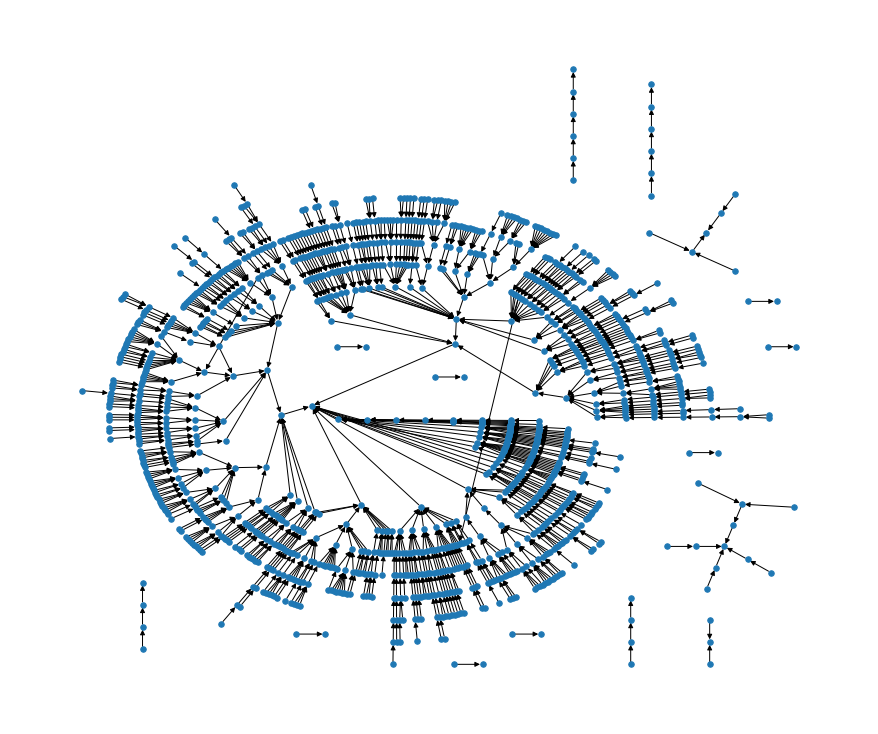

In [37]:
pos = graphviz_layout(G, prog="twopi")
nx.draw(G, pos, node_size=30)

### Team Analysis

In [38]:
teams = pd.DataFrame(nx.pagerank(G).items(), columns=['Employee_ThreeFour','PageRank'])

In [39]:
teams.sort_values('PageRank',ascending=False, ignore_index=True, inplace=True)

In [40]:
team_list = pd.merge(teams, positions, on='Employee_ThreeFour', how='left')

In [46]:
team_list.to_excel('v3/org_analysis_v3.xlsx')

In [45]:
nx.write_graphml(G, "v3/org_analysis_v3.graphml")